<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Resnet using Subclassing API

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import datetime
import io

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPool2D, BatchNormalization, Activation, Add

class IdentityBlock(Model):
  
  def __init__(self, filters, kernel_size, **kwargs):
    super().__init__(**kwargs)
    
    self.conv1 = Conv2D(filters, kernel_size, padding='same')
    self.bn1 = BatchNormalization()
    
    self.conv2 = Conv2D(filters, kernel_size, padding='same')
    self.bn2 = BatchNormalization()

    self.act = Activation('relu')
    self.add = Add()
  
  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.act(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.add([x, input_tensor])
    output = self.act(x)

    return output

In [ ]:
from keras.layers import GlobalAveragePooling2D

class MiniResnet(Model):

  def __init__(self, num_classes, **kwargs):
    super().__init__(**kwargs)

    self.conv = Conv2D(64, 7, padding='same')
    self.bn = BatchNormalization()
    self.maxpool = MaxPool2D((3,3))
    self.gap = GlobalAveragePooling2D()
    self.act = Activation('relu')

    self.idb1 = IdentityBlock(64, 3)
    self.idb2 = IdentityBlock(64, 3)

    self.classifier = Dense(num_classes, activation='softmax')

  def call(self, input):
    x = self.conv(input)
    x = self.bn(x)
    x = self.act(x)
    x = self.maxpool(x)

    x = self.idb1(x)
    x = self.idb2(x)

    x = self.gap(x)
    output = self.classifier(x)

    return output

In [ ]:
def preprocess(data):
  return tf.cast(data['image'], tf.float32) / 255., data['label']

In [ ]:
import tensorflow_datasets as tfds
resnet = MiniResnet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ds = tfds.load('mnist', split=tfds.Split.TRAIN)
ds = ds.map(preprocess).batch(32)

# resnet.fit(ds, epochs=1)

1875/1875 [==============================] - 212s 113ms/step - loss: 0.1283 - accuracy: 0.9651


## Custom callbacks

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val, X_train = X_train[50000:], X_train[:50000]
y_val, y_train = y_train[50000:], y_train[:50000]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Building the model architecture
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

K = keras.backend
K.clear_session()

model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=SGD(learning_rate=1e-2), 
              metrics=["accuracy"])

In [ ]:
class DetectOverfittingCB(keras.callbacks.Callback):

  def __init__(self, threshold=0.7):
    super(DetectOverfittingCB, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    ratio = logs['val_loss'] / logs['loss']
    print("\nEpoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

    if ratio > self.threshold:
      print("Overfitting detected. Stopping training...")
      self.model.stop_training = True

In [ ]:
from PIL import Image
from IPython.display import Image as IPyImage
import imageio

plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

GIF_PATH = './animation.gif'

In [ ]:
class VisCallback(keras.callbacks.Callback):

  def __init__(self, inputs, ground_truth, display_freq=5, n_samples=10):
    self.inputs = inputs
    self.ground_truth = ground_truth
    self.display_freq = display_freq
    self.n_samples = n_samples
    self.images = []

  def on_epoch_end(self, epoch, logs=None):
    indexes = np.random.choice(len(self.inputs), size=self.n_samples)
    X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
    predictions = np.argmax(self.model.predict(X_test), axis=-1)

    display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
    self.images.append(np.array(image))
    if epoch % self.display_freq == 0:
      plt.show()

  def on_train_end(self, logs=None):
    imageio.mimsave(GIF_PATH, self.images, fps=1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Model checkpoint
checkpoint_cb = ModelCheckpoint("mnist_first_model.h5", save_best_only=True)

# Checkpont for early stopping
earlystopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Custom callback that detects overfitting
detect_overfit_cb = DetectOverfittingCB(threshold=1.2)

# Custom visualization callback
viz_cb = VisCallback(X_val, y_val)

Epoch 1/10
1554/1563 [============================>.] - ETA: 0s - loss: 0.6360 - accuracy: 0.8402
Epoch: 0, Val/Train loss ratio: 0.48


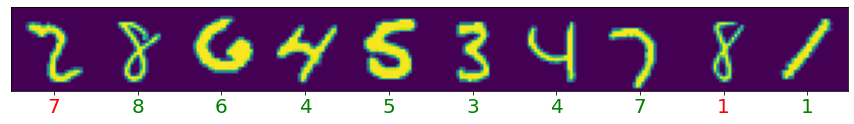

1563/1563 [==============================] - 8s 5ms/step - loss: 0.6346 - accuracy: 0.8405 - val_loss: 0.3052 - val_accuracy: 0.9146
Epoch 2/10
1552/1563 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9172
Epoch: 1, Val/Train loss ratio: 0.83
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2916 - accuracy: 0.9171 - val_loss: 0.2430 - val_accuracy: 0.9322
Epoch 3/10
1554/1563 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9312
Epoch: 2, Val/Train loss ratio: 0.87
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2396 - accuracy: 0.9312 - val_loss: 0.2077 - val_accuracy: 0.9419
Epoch 4/10
1558/1563 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9403
Epoch: 3, Val/Train loss ratio: 0.91
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2063 - accuracy: 0.9404 - val_loss: 0.1878 - val_accuracy: 0.9494
Epoch 5/10
1558/1563 [============================>.] - ETA: 0s

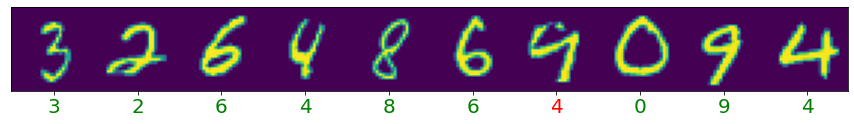

In [ ]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, earlystopping_cb, detect_overfit_cb, viz_cb])

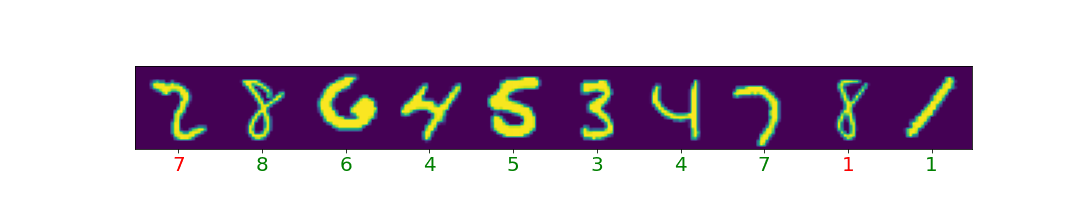

In [ ]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 